# 1. Imports

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

import random

import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_percentage_error

from xgboost import plot_importance

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from pathlib import Path

## 1.2. Loading data

In [2]:
FOLDER_PATH = Path("../data/processed")

In [3]:
df_train = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "train.csv", low_memory=False)
df_test = pd.read_csv(filepath_or_buffer=FOLDER_PATH / "test.csv", low_memory=False)

In [4]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
df_test["Date"] = pd.to_datetime(df_test["Date"])

# 2. Machine learning model

In [5]:
seed = 42

In [ ]:
#X_train = df_train.drop(columns=["Date", "Sales", "Customers", "Store"])
X_train = df_train.drop(columns=["Date", "Sales", "Customers"])
y_train = df_train[["Sales"]]

In [ ]:
#X_test = df_test.drop(columns=["Date", "Sales", "Customers", "Store"])
X_test = df_test.drop(columns=["Date", "Sales", "Customers"])
y_test = df_test[["Sales"]]

In [8]:
assert len(X_train.columns) == len(X_test.columns), 'Different columns between X_train and X_test'

## 4.1. XGBoost

In [9]:
def root_mean_square_percentage_error(y_true, y_pred):
    rmspe = np.sqrt(np.mean(((y_true.values.reshape(len(y_true)) - y_pred) / y_true.values.reshape(len(y_true)))**2))
    return rmspe

def model_performance(y_true, y_pred):
    rmspe = root_mean_square_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return pd.DataFrame({'RMSPE': rmspe,
                         'RMSE': rmse,
                         'MAPE': mape},
                         index=[0])

In [49]:
reg_xgb = xgb.XGBRegressor(n_estimators = 500, enable_categorical=True, tree_method="hist", random_state=seed)
reg_xgb.fit(X=X_train, y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [50]:
y_pred_xgb = reg_xgb.predict(X=X_test)

In [51]:
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.152703,877.18103,0.092154


### 4.1.2. Feature importances filtering

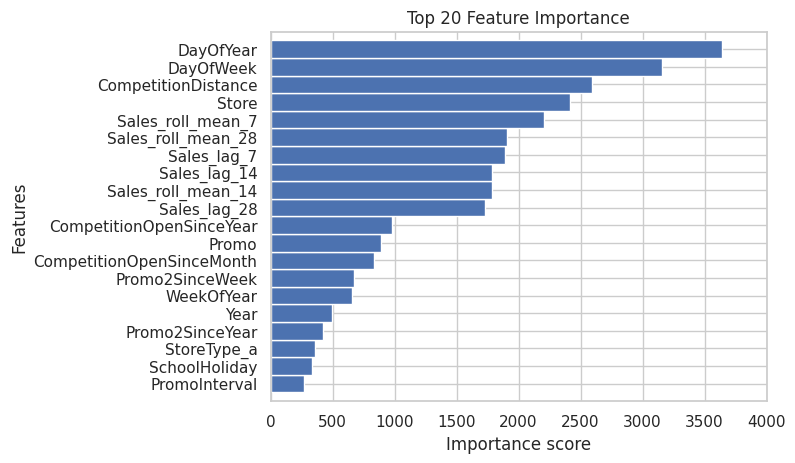

In [53]:
plot_importance(reg_xgb, importance_type="weight",
#plot_importance(reg_xgb, importance_type="gain",
                max_num_features=20,
                height=1,
                title="Top 20 Feature Importance",
                show_values=False);

In [54]:
importances = reg_xgb.get_booster().get_score(importance_type="weight")
#importances = reg_xgb.get_booster().get_score(importance_type="gain")

feature_importances = pd.DataFrame(list(importances.items()),
                                   columns=["Feature", "Importance"])\
                                  .set_index("Feature").sort_values(by="Importance", ascending=False)

In [55]:
k = 12

topKfeat = feature_importances.iloc[:k,:].index
topKfeat

Index(['DayOfYear', 'DayOfWeek', 'CompetitionDistance', 'Store',
       'Sales_roll_mean_7', 'Sales_roll_mean_28', 'Sales_lag_7',
       'Sales_lag_14', 'Sales_roll_mean_14', 'Sales_lag_28',
       'CompetitionOpenSinceYear', 'Promo'],
      dtype='object', name='Feature')

In [56]:
reg_xgb_filtered = xgb.XGBRegressor(n_estimators = 1000, enable_categorical=True, random_state=seed)
reg_xgb_filtered.fit(X=X_train[topKfeat], y=y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [57]:
y_pred_xgb_filtered = reg_xgb_filtered.predict(X=X_test[topKfeat])
model_performance(y_true=y_test, y_pred=y_pred_xgb_filtered)

,RMSPE,RMSE,MAPE
0,0.136857,908.374268,0.094338


### 4.1.3. Early stopping

In [58]:
def custom_rmspe(y_pred: np.ndarray, y_true: np.ndarray):
        rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))
        return rmspe

In [59]:
#early_stop = xgb.callback.EarlyStopping(
#    rounds=100,
#    data_name='validation_0',
#    metric_name="RMSPE",
#    maximize=False,
#    save_best=True
#)

reg_xgb_es = xgb.XGBRegressor(n_estimators = 1000,
                              learning_rate = 0.01,
                              enable_categorical=True,
                              tree_method="hist",
                              #callbacks = [early_stop],
                              early_stopping_rounds = 100,
                              eval_metric = custom_rmspe,
                              random_state=seed)

reg_xgb_es.fit(X=X_train[topKfeat],
               y=y_train,
               eval_set = [(X_test[topKfeat], y_test)],
               verbose=100)

[0]	validation_0-rmse:2913.84845	validation_0-custom_rmspe:0.41553
[100]	validation_0-rmse:1525.01923	validation_0-custom_rmspe:0.20765
[200]	validation_0-rmse:1194.01550	validation_0-custom_rmspe:0.16746
[300]	validation_0-rmse:1127.24199	validation_0-custom_rmspe:0.15852
[400]	validation_0-rmse:1107.93581	validation_0-custom_rmspe:0.15626
[500]	validation_0-rmse:1097.56064	validation_0-custom_rmspe:0.15510
[600]	validation_0-rmse:1088.52908	validation_0-custom_rmspe:0.15401
[700]	validation_0-rmse:1081.18010	validation_0-custom_rmspe:0.15330
[800]	validation_0-rmse:1071.52754	validation_0-custom_rmspe:0.15211
[900]	validation_0-rmse:1056.63286	validation_0-custom_rmspe:0.15012
[999]	validation_0-rmse:1041.23071	validation_0-custom_rmspe:0.14817


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=True,
             eval_metric=<function custom_rmspe at 0x7ed8b7b96b60>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [60]:
y_pred_xgb = reg_xgb_es.predict(X=X_test[topKfeat])
model_performance(y_true=y_test, y_pred=y_pred_xgb)

,RMSPE,RMSE,MAPE
0,0.177123,1041.230713,0.111937


### 4.1.3. Hyperparameter tunning

In [61]:
reg_xgb_tun = xgb.XGBRegressor(tree_method="hist",
                               eval_metric = custom_rmspe,
                               enable_categorical=True,
                               random_state=seed)

In [62]:
tscv = TimeSeriesSplit(n_splits=3)

In [63]:
xgb_space = {
    "n_estimators": Integer(100, 5000),
    "max_depth": Integer(3,10),
    "learning_rate": Real(0.001, 0.5, prior="log-uniform"),
    "subsample": Real(0.05, 1.0, prior="uniform"),
    "colsample_bytree": Real(0.1, 1.0, prior="uniform"),
    "min_child_weight": Real(1, 10),
    "reg_alpha": Real(0.0, 1.0, prior="uniform"),
    "reg_lambda": Real(0.0, 5.0, prior="uniform"),
    "gamma": Real(0.0, 5.0, prior="uniform")
}

reg_xgb_opt = BayesSearchCV(estimator=reg_xgb_tun,
                            search_spaces=xgb_space,
                            scoring="neg_root_mean_squared_error",
                            n_iter=10,
                            cv=tscv,
                            random_state=seed,
                            n_jobs=-1)

In [64]:
reg_xgb_opt.fit(X=X_train[topKfeat], y=y_train)

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric=<function custom_rmspe at 0x7ed8b7b96b60>,
                                     feature_types=No...
                             'min_child_weight': Real(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.0, high=5.0, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1.0, prior='uniform', transform='normalize')})

In [66]:
reg_xgb_opt.best_score_*(-1)

np.float64(1087.6634724934895)

In [67]:
best_params = reg_xgb_opt.best_params_

In [68]:
# Treino final com early stopping
final_model = xgb.XGBRegressor(**best_params,
                               early_stopping_rounds = 100,
                               eval_metric = custom_rmspe,)

In [69]:
# Treino final com early stopping
final_model.fit(
    X_train[topKfeat],
    y_train,
    eval_set=[(X_test[topKfeat], y_test)],
    verbose=100
)

[0]	validation_0-rmse:2917.49811	validation_0-custom_rmspe:0.41635
[100]	validation_0-rmse:1579.49343	validation_0-custom_rmspe:0.21412
[200]	validation_0-rmse:1176.37316	validation_0-custom_rmspe:0.16494
[300]	validation_0-rmse:1073.56592	validation_0-custom_rmspe:0.15120
[400]	validation_0-rmse:1039.27556	validation_0-custom_rmspe:0.14673
[500]	validation_0-rmse:1020.34525	validation_0-custom_rmspe:0.14440
[600]	validation_0-rmse:990.81364	validation_0-custom_rmspe:0.14081
[700]	validation_0-rmse:973.89289	validation_0-custom_rmspe:0.13925
[800]	validation_0-rmse:966.25225	validation_0-custom_rmspe:0.13855
[900]	validation_0-rmse:961.18440	validation_0-custom_rmspe:0.13805
[1000]	validation_0-rmse:958.02600	validation_0-custom_rmspe:0.13774
[1100]	validation_0-rmse:956.10602	validation_0-custom_rmspe:0.13755
[1200]	validation_0-rmse:954.23266	validation_0-custom_rmspe:0.13725
[1300]	validation_0-rmse:951.36728	validation_0-custom_rmspe:0.13678
[1400]	validation_0-rmse:949.51090	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6553714226520847, device=None,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=<function custom_rmspe at 0x7ed8b7b96b60>,
             feature_types=None, feature_weights=None, gamma=3.876821894139413,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.009310909900976862,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=6.33357707775011, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3014,
             n_jobs=None, num_parallel_tree=None, ...)

In [88]:
store_number = random.randint(1, X_train["Store"].nunique())

# O teste compreende as 6 últimas semanas portanto, a soma das predições por loja dará o total de vendas das próximas 6 semanas
next_six_week_sales = final_model.predict(X=X_test[X_test["Store"] == store_number][topKfeat]).sum()

print(f"A previão de vendas para a loja {store_number} é de US$ {next_six_week_sales:.2f} nas próximas seis semanas.")

A previão de vendas para a loja 298 é de US$ 123389.48 nas próximas seis semanas.


## Outras hipóteses
- treinar cada loja separadamente?

## 4.2. Validation